# Prepare training data

In [1]:
import pandas as pd
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import nltk
import matplotlib.pyplot as plt
import numpy as np
import scipy

Find each paper's author-assigned subcategory. If the paper has none, remove it from the data. 

In [115]:
metadata = pd.read_csv('../data/2020_03_06_arxiv_metadata_astroph/arxiv_metadata_astroph.csv')
print('Total number of papers: ' + str(len(metadata)))

# Specify the subdomains we want to target 
subdomains = {'astro-ph.SR': 'Solar and Stellar Astrophysics',
              'astro-ph.CO': 'Cosmology and Nongalactic Astrophysics',
              'astro-ph.GA': 'Astrophysics of Galaxies',
              'astro-ph.HE': 'High Energy Astrophysical Phenomena',
              'astro-ph.EP': 'Earth and Planetary Astrophysics',
              'astro-ph.IM': 'Instrumentation and Methods for Astrophysics'}

print('\nWe are keeping only papers that have been labeled with any of the following ' 
      + str(len(subdomains.keys())) + ' subdomains:\n' + str(subdomains.values()))

labels = metadata['categories'].str.split(' ')        # Get all labels for each paper
subdomain_labels = []     

for i, _ in enumerate(labels):                         # For each paper,
    temp = []                                          # create a temporary list of subdomain labels and
    has_subdomain_label = False                        # state that the paper has no subdomain labels yet
    for j,_ in enumerate(labels[i]):                   # For each of the paper's labels,
        if labels[i][j] in subdomains.keys():                 # if the paper has a subdomain label
            temp.append(labels[i][j])                  # add the subdomain label to that paper's subdomain labels list
            has_subdomain_label = True                 # and mark that the paper has at least one subdomain label
            
        if j == (len(labels[i]) - 1):                  # When done looking at the last label for that paper,
            if not has_subdomain_label:                # if that paper had no subdomain labels,
                subdomain_labels.append(None)          # add none to the master list
            else:                
                subdomain_labels.append(temp)          # otherwise note its subdomain labels 
                
metadata['subdomains'] = subdomain_labels
print('\nNumber of papers without subdomain labels: ' + str(len(papers_to_drop)))

Total number of papers: 267794

We are keeping only papers that have been labeled with any of the following 6 subdomains:
dict_values(['Solar and Stellar Astrophysics', 'Cosmology and Nongalactic Astrophysics', 'Astrophysics of Galaxies', 'High Energy Astrophysical Phenomena', 'Earth and Planetary Astrophysics', 'Instrumentation and Methods for Astrophysics'])

Number of papers without subdomain labels: 105283


### Visualize how the distribution of years may have changed as a result of dropping a chunk of papers

In [141]:
papers_with_no_subdomains = np.where(metadata['subdomains'].isna())[0]
years = pd.to_datetime(metadata['created']).apply(lambda x: x.year)
years_filtered = years.drop(papers_with_no_subdomains)
years_count = years.value_counts()
years_filtered_count = years_filtered.value_counts()

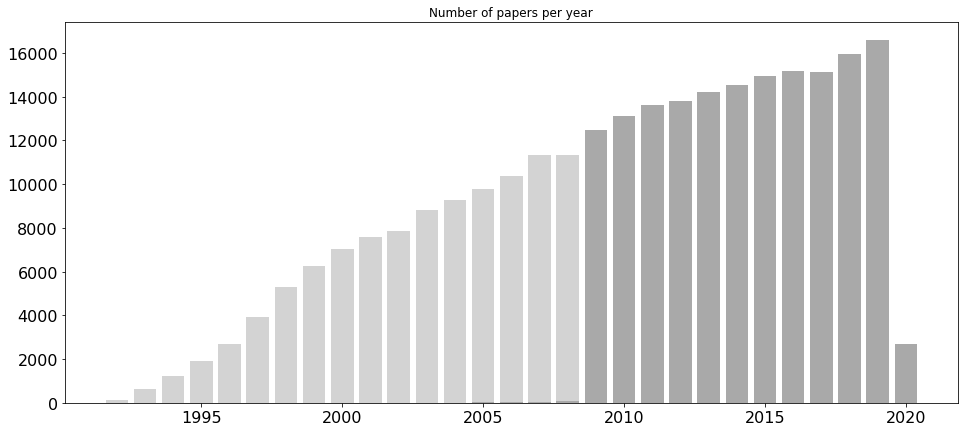

In [150]:
plt.figure(figsize=(16,7))
plt.bar(years_count.keys(), years_count.values, color='lightgray')
plt.bar(years_filtered_count.keys(), years_filtered_count.values, color='darkgray')
plt.title('Number of papers per year')
plt.show()

Very few papers were labeled in 2007, 2008, etc, but probably because their papers were revised 2009> and the authors had the option to add labels then. 

Looks like in 2009 they realized they should add finer granularity to the field, and introduced subdomain labels. 

Ensure that there are no papers after 2009 that didn't have subdomain labels. 

In [142]:
years.take(papers_with_no_subdomains).value_counts()

2007    11315
2008    11252
2006    10367
2005     9781
2004     9248
2003     8827
2002     7847
2001     7598
2000     7027
1999     6236
1998     5312
1997     3916
1996     2686
1995     1911
1994     1222
1993      617
1992      121
Name: created, dtype: int64

There are NO papers after 2009 that didn't have subdomain labels. This is great.

So we will focus on only papers from 2009-2019. 

**Remove abstracts outside 2009-2019.**

Since there are no papers within 2009-2019 that didn't have subdomain labels, we can just select all the papers within this range. 

In [100]:
papers_out_of_range = [i for i, isInRange in enumerate(years.apply(lambda x: x < 2009 or x > 2019)) if isInRange]
print('Number of papers outside 2009-2019: ' + str(len(papers_out_of_range)))
abstracts_filtered = pd.Series(abstracts).drop(papers_out_of_range)
print('Number of papers within 2009-2019: ' + str(len(abstracts_filtered)))

Number of papers outside 2009-2019: 108178
Number of papers within 2009-2019: 159616


### Visualize subdomain distribution within 2009-2019

In [153]:
subdomain_distribution = pd.Series([subdomain for subdomains in metadata['subdomains'].drop(papers_out_of_range) for subdomain in subdomains]).value_counts()

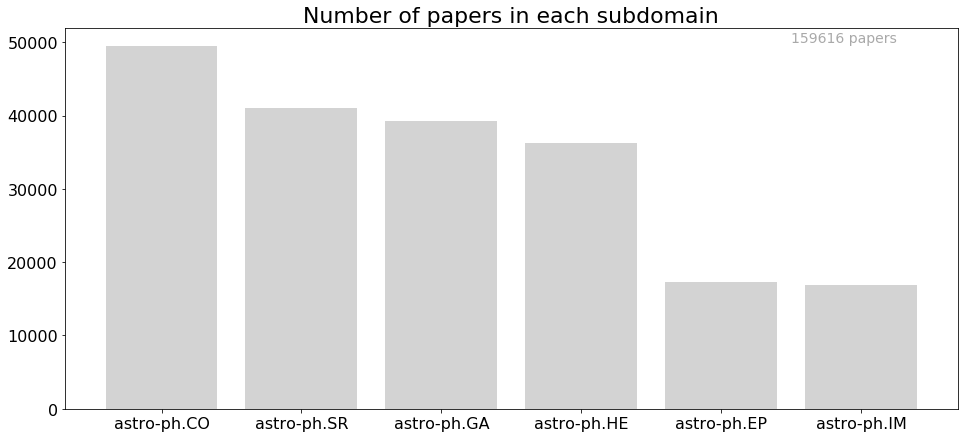

In [155]:
plt.figure(figsize=(16,7))
plt.bar(subdomain_distribution.keys(), subdomain_distribution.values, color='lightgray')
plt.title('Number of papers in each subdomain', fontdict=dict(size=22))
plt.text(4.5, 50000, str(len(abstracts_filtered)) + ' papers', size=14, color='darkgray')
plt.show()

**Distribution of abstract word counts.**

We can see that the most common length of abstracts is 250 words which makes sense given the 250-word limit that journals often have.

*WILL DO THIS FOR FULL TEXTS TOO.*

In [7]:
abstracts = [abstract.replace('\n', ' ').strip() for abstract in metadata['abstract']]
abstracts_word_count = [len(abstract.split(' ')) for abstract in abstracts]
abstracts_filtered_word_count = list(pd.Series(abstracts_word_count).drop(papers_to_drop))

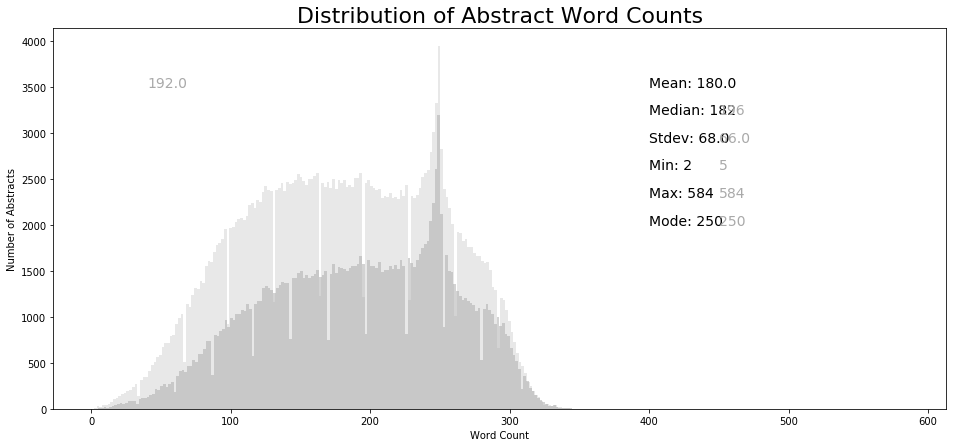

In [8]:
plt.figure(figsize=(16,7))
plt.hist(abstracts_word_count, bins=300, color='lightgray', alpha=0.5)
plt.text(400, 3500, "Mean: " + str(round(np.mean(abstracts_word_count))), size=14)
plt.text(400, 3200, "Median: " + str(int(round(np.median(abstracts_word_count)))), size=14)
plt.text(400, 2900, "Stdev: " + str(round(np.std(abstracts_word_count))), size=14)
plt.text(400, 2600, "Min: " + str(round(np.min(abstracts_word_count))), size=14)
plt.text(400, 2300, "Max: " + str(round(np.max(abstracts_word_count))), size=14)
plt.text(400, 2000, "Mode: " + str(scipy.stats.mode(abstracts_word_count)[0][0]), size=14)
plt.gca().set(ylabel='Number of Abstracts', xlabel='Word Count')
plt.title('Distribution of Abstract Word Counts', fontdict=dict(size=22))
plt.rc('xtick',labelsize=16)
plt.rc('axes',labelsize=16)
plt.rc('ytick',labelsize=16)

plt.hist(abstracts_filtered_word_count, bins=300, color='darkgray', alpha=0.5)
plt.text(40, 3500, str(round(np.mean(abstracts_filtered_word_count))), size=14, color='darkgray')
plt.text(450, 3200, str(int(round(np.median(abstracts_filtered_word_count)))), size=14, color='darkgray')
plt.text(450, 2900, str(round(np.std(abstracts_filtered_word_count))), size=14, color='darkgray')
plt.text(450, 2600, str(round(np.min(abstracts_filtered_word_count))), size=14, color='darkgray')
plt.text(450, 2300, str(round(np.max(abstracts_filtered_word_count))), size=14, color='darkgray')
plt.text(450, 2000, str(scipy.stats.mode(abstracts_filtered_word_count)[0][0]), size=14, color='darkgray')

plt.show()

How to decide optimal number of bins? https://stats.stackexchange.com/questions/798/calculating-optimal-number-of-bins-in-a-histogram

One solution is to create a graph that shows every value. Either a dot plot, or a cumulative frequency distribution, which doesn't require any bins. *This took too long to plot.*

If you use too few bins, the histogram doesn't really portray the data very well. If you have too many bins, you get a broken comb look, which also doesn't give a sense of the distribution. The simplest method is to set the number of bins equal to the square root of the number of values you are binning.

I just ended up eyeing it. 

## Tokenize abstracts into our training corpus

Usual steps involved in data preprocessing. 

- Stemming/lemmatizing
- Converting all words to lower case
- Punctuation removal 
- Stop word removal
- Converting numerics to words (e.g. 1990 to one nine nine zero) 

The word2vec/doc2vec are often different. For example, the original word2vec paper and evaluations didn't mention any stemming/lemmatization or stop-word removal and retained punctuation as word-like tokens. The original Paragraph Vector paper and its follow-up seem to do things similarly — with no mention of extra preprocessing before calculating doc-vectors. 

But it's possible that the influence of stopwords and punctuation may be different in word2vec/doc2vec training than in other forms of NLP. 

https://www.ep.liu.se/ecp/131/039/ecp17131039.pdf
- Stop-word removal increases window size.

**However, performance is strongly correlated with the performance on downstream tasks. So in the end we of course want to test on our practical application.**

In [114]:
words = [nltk.word_tokenize(_d.lower()) for i,_d in enumerate(abstracts_filtered)]

In [157]:
words[0]

['we',
 'compute',
 'the',
 'probability',
 'distribution',
 'for',
 'bubble',
 'collisions',
 'in',
 'an',
 'inflating',
 'false',
 'vacuum',
 'which',
 'decays',
 'by',
 'bubble',
 'nucleation',
 '.',
 'our',
 'analysis',
 'generalizes',
 'previous',
 'work',
 'of',
 'guth',
 ',',
 'garriga',
 ',',
 'and',
 'vilenkin',
 'to',
 'the',
 'case',
 'of',
 'general',
 'cosmological',
 'evolution',
 'inside',
 'the',
 'bubble',
 ',',
 'and',
 'takes',
 'into',
 'account',
 'the',
 'dynamics',
 'of',
 'the',
 'domain',
 'walls',
 'that',
 'form',
 'between',
 'the',
 'colliding',
 'bubbles',
 '.',
 'we',
 'find',
 'that',
 'incorporating',
 'these',
 'effects',
 'changes',
 'the',
 'results',
 'dramatically',
 ':',
 'the',
 'total',
 'expected',
 'number',
 'of',
 'bubble',
 'collisions',
 'in',
 'the',
 'past',
 'lightcone',
 'of',
 'a',
 'typical',
 'observer',
 'is',
 'n',
 '~',
 '\\gamma',
 'v_f',
 '/',
 'v_i',
 ',',
 'where',
 '\\gamma',
 'is',
 'the',
 'fastest',
 'decay',
 'rate',
 'o

In [89]:
training_data = [TaggedDocument(words=words, tags=[str(i)])]

In [90]:
training_data[0]

TaggedDocument(words=['we', 'compute', 'the', 'probability', 'distribution', 'for', 'bubble', 'collisions', 'in', 'an', 'inflating', 'false', 'vacuum', 'which', 'decays', 'by', 'bubble', 'nucleation', '.', 'our', 'analysis', 'generalizes', 'previous', 'work', 'of', 'guth', ',', 'garriga', ',', 'and', 'vilenkin', 'to', 'the', 'case', 'of', 'general', 'cosmological', 'evolution', 'inside', 'the', 'bubble', ',', 'and', 'takes', 'into', 'account', 'the', 'dynamics', 'of', 'the', 'domain', 'walls', 'that', 'form', 'between', 'the', 'colliding', 'bubbles', '.', 'we', 'find', 'that', 'incorporating', 'these', 'effects', 'changes', 'the', 'results', 'dramatically', ':', 'the', 'total', 'expected', 'number', 'of', 'bubble', 'collisions', 'in', 'the', 'past', 'lightcone', 'of', 'a', 'typical', 'observer', 'is', 'n', '~', '\\gamma', 'v_f', '/', 'v_i', ',', 'where', '\\gamma', 'is', 'the', 'fastest', 'decay', 'rate', 'of', 'the', 'false', 'vacuum', ',', 'v_f', 'is', 'its', 'vacuum', 'energy', ',',

### Parameters to change:

- `window` — size of the sliding window used to parse texts
- `alpha` — initial learning rate of the network
- `sample` — allows the model to reduce the importance given to high-frequency words
- `dm` — training algorithm (PV-DM or PV-DBOW)
- `hs` — whether hierarchical softmax or negative sampling is used during training
- `dimensions` 

Default values:
- `window_size` — 5
- `alpha` — 
- `sample` – 
- `dm` – 1 (PV-DM)
- `hs` – 

Possible values: 

How to use bash:

1. Create a file named `bash_practice` in Sublime, Text Edit etc. with some example bash script, e.g. 

```
#!/bin/bash
echo hello world
```

2. `chmod 700 bash_practice`
3. `./bash_practice`

It will output "hello world".